In [1]:
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
import sys
sys.path.append("../")
from models.base import BaseVAE
from data.two_moon import TwoMoonDataset
from torch import nn
from torch.utils.data import DataLoader
from torchmetrics import MetricCollection, Metric
import torch

In [2]:
X, y = make_moons(n_samples=1000, noise=0.)

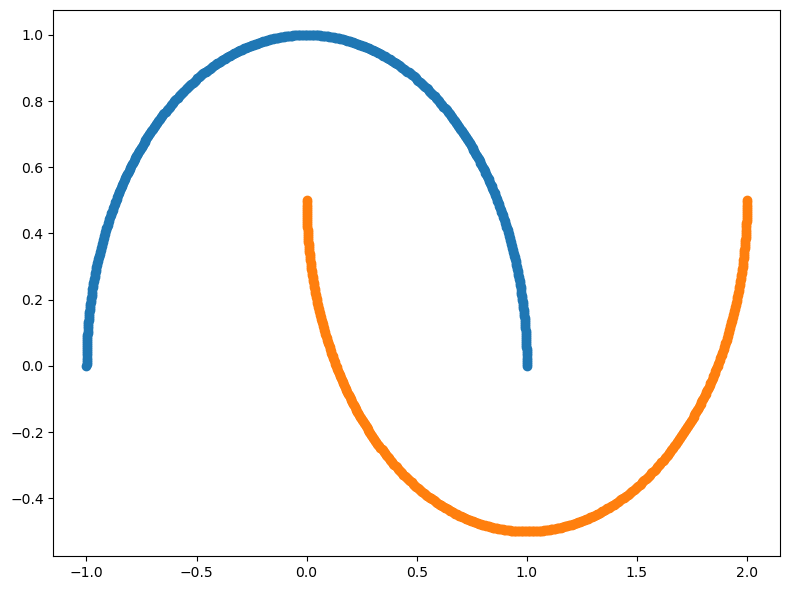

In [3]:
fig = plt.figure(figsize=(8,6))

plt.scatter(X[y==0, 0], X[y==0, 1], label="y=0")
plt.scatter(X[y==1, 0], X[y==1, 1], label="y=1")


plt.tight_layout()
plt.show()

In [2]:

class VAE(BaseVAE):

    def __init__(self, hparams):
        super().__init__(hparams)

        self.x_dim, self.sample_dim, self.cond_dim = hparams['x_dim'], hparams['sample_dim'], hparams['cond_dim']
        encoder = []
        decoder = []
        for in_dim, out_dim in zip([self.x_dim + self.cond_dim] + hparams['enc_hidden_dim'][:-1], hparams['enc_hidden_dim']) :
            encoder.append(nn.Linear(in_dim, out_dim))
            encoder.append(getattr(nn, hparams['hidden_activation'])())
        encoder.append(nn.Linear(hparams['enc_hidden_dim'][-1], self.sample_dim * 2))

        for in_dim, out_dim in zip([self.sample_dim + self.cond_dim] + hparams['dec_hidden_dim'][:-1], hparams['dec_hidden_dim']) :
            decoder.append(nn.Linear(in_dim, out_dim))
            decoder.append(getattr(nn, hparams['hidden_activation'])())
        decoder.append(nn.Linear(hparams['dec_hidden_dim'][-1], self.x_dim))
        
        self.encoder = nn.Sequential(*encoder)
        self.decoder = nn.Sequential(*decoder)

        self.batch_size = hparams['batch_size']
        self.n_samples = hparams.get("n_samples") or 1
    
    def encode(self, x, cond=None):
        if cond is not None:
            x_in = torch.concat([x, cond], dim=-1)
        
        return self.encoder(x_in)
    
    def decode(self, sample, cond=None):
        if cond is not None:
            x_in = torch.concat([sample, cond], dim=-1)
        
        return self.decoder(x_in)

    def sample_prior(self, cond):
        z = torch.rand((cond.size(0), self.sample_dim)).to(self.device)

        return self.decode(z, cond)
    
    def forward(self, x, cond=None):

        encoded_ = self.encode(x, cond)

        mu_z = encoded_[:, : self.sample_dim]

        log_var_z = encoded_[:, self.sample_dim :]

        sample = self.reparameterize(mu_z, log_var_z)

        x_out = [self.decode(sample, cond) for _ in range(self.n_samples)]

        # decoded_ = self.decode(sample, cond)

        # mu_x, log_var_x = decoded_[:, : self.x_dim], decoded_[:, self.x_dim :]

        # x_out = self.reparameterize(mu_x, log_var_x)

        # x_out = decoded_

        # return x_out, mu_x, log_var_x, mu_z, log_var_z
        return x_out, 0,0, mu_z, log_var_z
    
    def loss_function(self, X_hat, mu_x, log_var_x, mu_z, log_var_z, X):

        kl_div = 0.5 * torch.mean(torch.sum(log_var_z - torch.exp(log_var_z) - torch.pow(mu_z, 2), dim=-1), dim=0) # ommit the constant 1

        # reco_loss = - 0.5 * torch.mean( torch.sum( log_var_x + torch.pow( (X - mu_x), 2) / log_var_z.exp(), dim=-1), dim=0)

        reco_loss = [nn.functional.mse_loss(x_hat, X) for x_hat in X_hat]
        reco_loss = sum(reco_loss) / self.n_samples

        loss = - kl_div + reco_loss 

        return kl_div, reco_loss, loss


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), self.hparams['learning_rate'])

    def training_step(self, X, y):
        
        x_out, mu_x, log_var_x, mu_z, log_var_z = self(X, y)

        kl_div, reco_loss, loss = self.loss_function(x_out, mu_x, log_var_x, mu_z, log_var_z, X)

        self.log_dict({
            "train_loss": loss,
            "train_kl_div": kl_div,
            "train_reco_loss": reco_loss
        }, on_step=False, on_epoch=True, batch_size=self.batch_size)
    
        return loss

    def validation_step(self, X, y):

        x_out, mu_x, log_var_x, mu_z, log_var_z = self(X, y)

        kl_div, reco_loss, loss = self.loss_function(x_out, mu_x, log_var_x, mu_z, log_var_z, X)

        self.log_dict({
            "val_loss": loss,
            "val_kl_div": kl_div,
            "val_reco_loss": reco_loss
        }, on_step=False, on_epoch=True, batch_size=self.batch_size)
    
        return loss


In [39]:
class VAEWithGaussianDecoder(VAE):

    def __init__(self, hparams):
        super().__init__(hparams)

        decoder = []

        for in_dim, out_dim in zip([self.sample_dim + self.cond_dim] + hparams['dec_hidden_dim'][:-1], hparams['dec_hidden_dim']) :
            decoder.append(nn.Linear(in_dim, out_dim))
            decoder.append(getattr(nn, hparams['hidden_activation'])())
        decoder.append(nn.Linear(hparams['dec_hidden_dim'][-1], self.x_dim * 2))
    
        self.decoder = nn.Sequential(*decoder)
    
    def forward(self, x, cond=None):

        encoded_ = self.encode(x, cond)

        mu_z = encoded_[:, : self.sample_dim]

        log_var_z = encoded_[:, self.sample_dim :]

        sample = self.reparameterize(mu_z, log_var_z)

        # x_out = [self.decode(sample, cond) for _ in range(self.n_samples)]

        decoded_ = self.decode(sample, cond)

        mu_x, log_var_x = decoded_[:, : self.x_dim], decoded_[:, self.x_dim :]

        x_out = [self.reparameterize(mu_x, log_var_x) for _ in range(self.n_samples)]

        # return x_out, mu_x, log_var_x, mu_z, log_var_z
        return x_out, mu_x, log_var_x, mu_z, log_var_z

    def loss_function(self, X_hat, mu_x, log_var_x, mu_z, log_var_z, X):

        kl_div = 0.5 * torch.mean(torch.sum(log_var_z - torch.exp(log_var_z) - torch.pow(mu_z, 2), dim=-1), dim=0) # ommit the constant 1

        # reco_loss = - 0.5 * torch.mean( torch.sum( log_var_x + torch.pow( (X - mu_x), 2) / log_var_z.exp(), dim=-1), dim=0)
        reco_loss = 0.5 * torch.mean( log_var_x + (X - mu_x) ** 2 / log_var_x.exp() )
        # reco_loss = [nn.functional.mse_loss(x_hat, X) for x_hat in X_hat]
        # reco_loss = sum(reco_loss) / self.n_samples

        loss = - kl_div + reco_loss 

        return kl_div, reco_loss, loss

    def sample_prior(self, cond):
        z = torch.rand((cond.size(0), self.sample_dim)).to(self.device)

        decoded_ = self.decode(z, cond)

        mu_x, log_var_x = decoded_[:, : self.x_dim], decoded_[:, self.x_dim :]

        return self.reparameterize(mu_x, log_var_x)
    

In [5]:
class VAEWithGaussianDecoderSampleZ(VAE):

    def __init__(self, hparams):
        super().__init__(hparams)

        decoder = []

        for in_dim, out_dim in zip([self.sample_dim + self.cond_dim] + hparams['dec_hidden_dim'][:-1], hparams['dec_hidden_dim']) :
            decoder.append(nn.Linear(in_dim, out_dim))
            decoder.append(getattr(nn, hparams['hidden_activation'])())
        # decoder.append(nn.Linear(hparams['dec_hidden_dim'][-1], hparams['dec_hidden_dim'][-1]))
        # decoder.append(nn.Tanh())
        decoder.append(nn.Linear(hparams['dec_hidden_dim'][-1], self.x_dim))
    
        self.decoder = nn.Sequential(*decoder)
    
    def forward(self, x, cond=None):

        encoded_ = self.encode(x, cond)

        mu_z = encoded_[:, : self.sample_dim]

        log_var_z = encoded_[:, self.sample_dim :]

        # samples = [self.reparameterize(mu_z, log_var_z) for _ in range(self.n_samples)]
        sample = self.reparameterize(mu_z, log_var_z)

        # x_out = [self.decode(sample, cond) for _ in range(self.n_samples)]

        # decoded_ = [self.decode(sample, cond) for sample in samples]
        decoded_ = self.decode(sample, cond)

        # mu_x, log_var_x = [_[:, : self.x_dim] for _ in decoded_], [_[:, self.x_dim :] for _ in decoded_]

        # x_out = [self.reparameterize(mu_x, log_var_x) for _ in range(self.n_samples)]
        # x_out = [mu_x for _ in range(self.n_samples)]

        # return x_out, mu_x, log_var_x, mu_z, log_var_z
        return decoded_, 0, 0, mu_z, log_var_z

    def loss_function(self, X_hat, mu_x, log_var_x, mu_z, log_var_z, X):

        kl_div = 0.5 * torch.mean(torch.sum(log_var_z - torch.exp(log_var_z) - torch.pow(mu_z, 2), dim=-1), dim=0) # ommit the constant 1

        # reco_loss = - 0.5 * torch.mean( torch.sum( log_var_x + torch.pow( (X - mu_x), 2) / log_var_z.exp(), dim=-1), dim=0)
        # reco_loss = [0.5 * torch.mean( log_var_x_ + (X - mu_x_) ** 2 / log_var_x_.exp() ) for log_var_x_, mu_x_ in zip(log_var_x, mu_x)]
        # reco_loss = [nn.functional.mse_loss(mu_x_, X) for mu_x_ in mu_x]

        reco_loss = 0.5 * torch.sum((X-X_hat)**2 )

        # reco_loss = sum(reco_loss) / self.n_samples
        # reco_loss = [nn.functional.mse_loss(x_hat, X) for x_hat in X_hat]
        # reco_loss = sum(reco_loss) / self.n_samples

        loss = - kl_div + reco_loss 

        return kl_div, reco_loss, loss

    def sample_prior(self, cond):
        z = torch.rand((cond.size(0), self.sample_dim)).to(self.device)

        decoded_ = self.decode(z, cond)

        # mu_x, log_var_x = decoded_[:, : self.x_dim], decoded_[:, self.x_dim :]

        # return mu_x
        return decoded_
    

In [78]:
class VAEWithGaussianDecoderSampleZV2(VAE):

    def __init__(self, hparams):
        super().__init__(hparams)

        decoder = []

        for in_dim, out_dim in zip([self.sample_dim + self.cond_dim] + hparams['dec_hidden_dim'][:-1], hparams['dec_hidden_dim']) :
            decoder.append(nn.Linear(in_dim, out_dim))
            decoder.append(getattr(nn, hparams['hidden_activation'])())
        # decoder.append(nn.Linear(hparams['dec_hidden_dim'][-1], hparams['dec_hidden_dim'][-1]))
        # decoder.append(nn.Tanh())
        decoder.append(nn.Linear(hparams['dec_hidden_dim'][-1], self.x_dim * 2))
    
        self.decoder = nn.Sequential(*decoder)
    
    def forward(self, x, cond=None):

        encoded_ = self.encode(x, cond)

        mu_z = encoded_[:, : self.sample_dim]

        log_var_z = encoded_[:, self.sample_dim :]

        # samples = [self.reparameterize(mu_z, log_var_z) for _ in range(self.n_samples)]
        sample = self.reparameterize(mu_z, log_var_z)

        # x_out = [self.decode(sample, cond) for _ in range(self.n_samples)]

        # decoded_ = [self.decode(sample, cond) for sample in samples]
        decoded_ = self.decode(sample, cond)

        mu_x, log_var_x = decoded_[:, : self.x_dim], decoded_[:, self.x_dim :] 

        # mu_x, log_var_x = [_[:, : self.x_dim] for _ in decoded_], [_[:, self.x_dim :] for _ in decoded_]

        # x_out = [self.reparameterize(mu_x, log_var_x) for _ in range(self.n_samples)]
        # x_out = [mu_x for _ in range(self.n_samples)]

        # return x_out, mu_x, log_var_x, mu_z, log_var_z
        return decoded_, mu_x, log_var_x, mu_z, log_var_z

    def loss_function(self, X_hat, mu_x, log_var_x, mu_z, log_var_z, X):

        kl_div = 0.5 * torch.mean(torch.sum(log_var_z - torch.exp(log_var_z) - torch.pow(mu_z, 2), dim=-1), dim=0) # ommit the constant 1

        # reco_loss = - 0.5 * torch.mean( torch.sum( log_var_x + torch.pow( (X - mu_x), 2) / log_var_z.exp(), dim=-1), dim=0)
        # reco_loss = [0.5 * torch.mean( log_var_x_ + (X - mu_x_) ** 2 / log_var_x_.exp() ) for log_var_x_, mu_x_ in zip(log_var_x, mu_x)]
        # reco_loss = [nn.functional.mse_loss(mu_x_, X) for mu_x_ in mu_x]

        reco_loss = 0.5 * torch.sum( torch.sum( log_var_x + (X-mu_x) **2 / log_var_x.exp(), dim=1 ), dim=0)

        # reco_loss = 0.5 * torch.sum((X-X_hat)**2 )

        # reco_loss = sum(reco_loss) / self.n_samples
        # reco_loss = [nn.functional.mse_loss(x_hat, X) for x_hat in X_hat]
        # reco_loss = sum(reco_loss) / self.n_samples

        loss = - kl_div + reco_loss 

        return kl_div, reco_loss, loss

    def sample_prior(self, cond):
        z = torch.rand((cond.size(0), self.sample_dim)).to(self.device)

        decoded_ = self.decode(z, cond)

        # mu_x, log_var_x = decoded_[:, : self.x_dim], decoded_[:, self.x_dim :]

        # return mu_x
        return decoded_
    

In [77]:
class VAEWithGaussianDecoderSampleZV3(VAE):

    def __init__(self, hparams):
        super().__init__(hparams)

        decoder = []

        for in_dim, out_dim in zip([self.sample_dim + self.cond_dim] + hparams['dec_hidden_dim'][:-1], hparams['dec_hidden_dim']) :
            decoder.append(nn.Linear(in_dim, out_dim))
            decoder.append(getattr(nn, hparams['hidden_activation'])())
        # decoder.append(nn.Linear(hparams['dec_hidden_dim'][-1], hparams['dec_hidden_dim'][-1]))
        # decoder.append(nn.Tanh())
        decoder.append(nn.Linear(hparams['dec_hidden_dim'][-1], self.x_dim * 2))
    
        self.decoder = nn.Sequential(*decoder)
    
    def forward(self, x, cond=None):

        encoded_ = self.encode(x, cond)

        mu_z = encoded_[:, : self.sample_dim]

        log_var_z = encoded_[:, self.sample_dim :]

        # samples = [self.reparameterize(mu_z, log_var_z) for _ in range(self.n_samples)]
        sample = self.reparameterize(mu_z, log_var_z)

        # x_out = [self.decode(sample, cond) for _ in range(self.n_samples)]

        # decoded_ = [self.decode(sample, cond) for sample in samples]
        decoded_ = self.decode(sample, cond)

        mu_x, log_var_x = decoded_[:, : self.x_dim], decoded_[:, self.x_dim :] 

        # mu_x, log_var_x = [_[:, : self.x_dim] for _ in decoded_], [_[:, self.x_dim :] for _ in decoded_]

        # x_out = [self.reparameterize(mu_x, log_var_x) for _ in range(self.n_samples)]
        # x_out = [mu_x for _ in range(self.n_samples)]

        # return x_out, mu_x, log_var_x, mu_z, log_var_z
        return decoded_, mu_x, log_var_x, mu_z, log_var_z

    def loss_function(self, X_hat, mu_x, log_var_x, mu_z, log_var_z, X):

        kl_div = 0.5 * torch.sum(torch.sum(log_var_z - torch.exp(log_var_z) - torch.pow(mu_z, 2), dim=-1), dim=0) # ommit the constant 1

        # reco_loss = - 0.5 * torch.mean( torch.sum( log_var_x + torch.pow( (X - mu_x), 2) / log_var_z.exp(), dim=-1), dim=0)
        # reco_loss = [0.5 * torch.mean( log_var_x_ + (X - mu_x_) ** 2 / log_var_x_.exp() ) for log_var_x_, mu_x_ in zip(log_var_x, mu_x)]
        # reco_loss = [nn.functional.mse_loss(mu_x_, X) for mu_x_ in mu_x]

        reco_loss = 0.5 * torch.sum( torch.sum( log_var_x + (X-mu_x) **2 / log_var_x.exp(), dim=1 ), dim=0)

        # reco_loss = 0.5 * torch.sum((X-X_hat)**2 )

        # reco_loss = sum(reco_loss) / self.n_samples
        # reco_loss = [nn.functional.mse_loss(x_hat, X) for x_hat in X_hat]
        # reco_loss = sum(reco_loss) / self.n_samples

        loss = - kl_div + reco_loss 

        return kl_div, reco_loss, loss

    def sample_prior(self, cond):
        z = torch.rand((cond.size(0), self.sample_dim)).to(self.device)

        decoded_ = self.decode(z, cond)

        # mu_x, log_var_x = decoded_[:, : self.x_dim], decoded_[:, self.x_dim :]

        # return mu_x
        return decoded_
    

In [105]:
class VAEWithGaussianDecoderSampleZV4(VAE):

    def __init__(self, hparams):
        super().__init__(hparams)

        decoder = []

        for in_dim, out_dim in zip([self.sample_dim + self.cond_dim] + hparams['dec_hidden_dim'][:-1], hparams['dec_hidden_dim']) :
            decoder.append(nn.Linear(in_dim, out_dim))
            decoder.append(getattr(nn, hparams['hidden_activation'])())
        # decoder.append(nn.Linear(hparams['dec_hidden_dim'][-1], hparams['dec_hidden_dim'][-1]))
        # decoder.append(nn.Tanh())
        decoder.append(nn.Linear(hparams['dec_hidden_dim'][-1], self.x_dim * 2))
    
        self.decoder = nn.Sequential(*decoder)
    
    def forward(self, x, cond=None):

        encoded_ = self.encode(x, cond)

        mu_z = encoded_[:, : self.sample_dim]

        log_var_z = encoded_[:, self.sample_dim :]

        # samples = [self.reparameterize(mu_z, log_var_z) for _ in range(self.n_samples)]
        sample = self.reparameterize(mu_z, log_var_z)

        # x_out = [self.decode(sample, cond) for _ in range(self.n_samples)]

        # decoded_ = [self.decode(sample, cond) for sample in samples]

        mu_x = []
        log_var_x = []

        for _ in range(self.n_samples):
            decoded_ = self.decode(sample, cond)
            mu_x.append(decoded_[:, : self.x_dim]) 
            log_var_x.append(decoded_[:, self.x_dim :] )

        # mu_x, log_var_x = [_[:, : self.x_dim] for _ in decoded_], [_[:, self.x_dim :] for _ in decoded_]

        # x_out = [self.reparameterize(mu_x, log_var_x) for _ in range(self.n_samples)]
        # x_out = [mu_x for _ in range(self.n_samples)]

        # return x_out, mu_x, log_var_x, mu_z, log_var_z
        return decoded_, mu_x, log_var_x, mu_z, log_var_z

    def loss_function(self, X_hat, mu_x, log_var_x, mu_z, log_var_z, X):

        kl_div = 0.5 * torch.sum(torch.sum(log_var_z - torch.exp(log_var_z) - torch.pow(mu_z, 2), dim=-1), dim=0) # ommit the constant 1

        # reco_loss = - 0.5 * torch.mean( torch.sum( log_var_x + torch.pow( (X - mu_x), 2) / log_var_z.exp(), dim=-1), dim=0)
        # reco_loss = [0.5 * torch.mean( log_var_x_ + (X - mu_x_) ** 2 / log_var_x_.exp() ) for log_var_x_, mu_x_ in zip(log_var_x, mu_x)]
        # reco_loss = [nn.functional.mse_loss(mu_x_, X) for mu_x_ in mu_x]

        mu_x = torch.stack(mu_x, dim=0)
        log_var_x = torch.stack(log_var_x, dim=0)

        reco_loss = 0.5 * torch.sum( torch.sum( torch.mean(log_var_x + (X-mu_x) **2 / log_var_x.exp(), dim=0) , dim=1), dim=0)

        # reco_loss = 0.5 * torch.sum((X-X_hat)**2 )

        # reco_loss = sum(reco_loss) / self.n_samples
        # reco_loss = [nn.functional.mse_loss(x_hat, X) for x_hat in X_hat]
        # reco_loss = sum(reco_loss) / self.n_samples

        loss = - kl_div + reco_loss 

        return kl_div, reco_loss, loss

    def sample_prior(self, cond):
        z = torch.rand((cond.size(0), self.sample_dim)).to(self.device)

        decoded_ = self.decode(z, cond)

        # mu_x, log_var_x = decoded_[:, : self.x_dim], decoded_[:, self.x_dim :]

        # return mu_x
        return decoded_
    

In [6]:
dataset = TwoMoonDataset()
train_dataloader = DataLoader(dataset, batch_size=1)

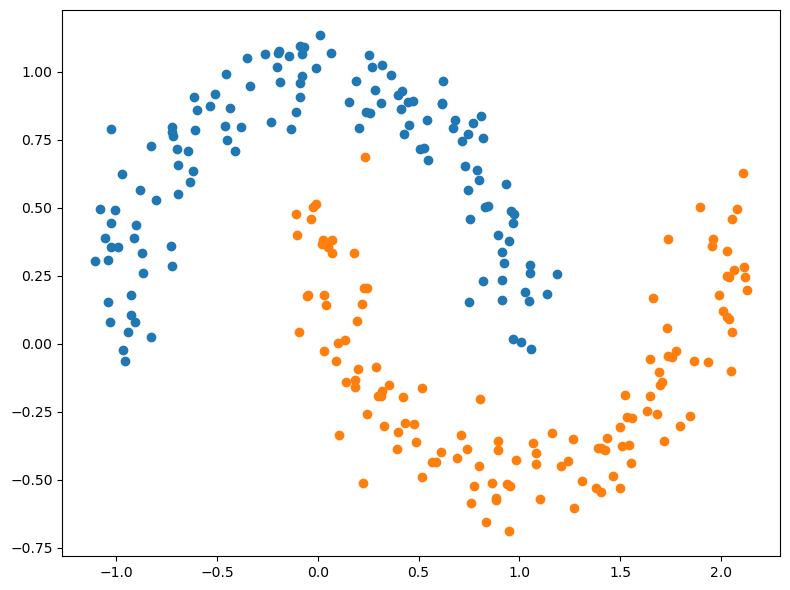

In [10]:
for X, y in train_dataloader:
    X = X[0]
    y=y[0]
    break

fig = plt.figure(figsize=(8,6))

plt.scatter(X[y==0, 0], X[y==0, 1], label="y=0")
plt.scatter(X[y==1, 0], X[y==1, 1], label="y=1")


plt.tight_layout()
plt.show()

In [4]:
hparams = dict(
    x_dim=2,
    sample_dim=2,
    cond_dim=1,
    enc_hidden_dim=[32,32,32,32],
    dec_hidden_dim=[32,32,32,32],
    hidden_activation='LeakyReLU',
    batch_size=256,
    learning_rate=0.0001,
    n_samples = 20
)

model = VAE(hparams).cuda()
model

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=32, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [32]:
n_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), 0.001)

for i in range(n_epochs):
    train_loss, train_kl_loss, train_reco_loss = 0,0,0
    for X, y in train_dataloader:

        optimizer.zero_grad()

        X, y = X[0].to(model.device), y[0].view(-1, 1).to(model.device)
        
        x_out, mu_x, log_var_x, mu_z, log_var_z = model(X, y)

        kl_div, reco, loss = model.loss_function(x_out, mu_x, log_var_x, mu_z, log_var_z, X)

        loss.backward()

        optimizer.step()

        train_loss += loss.detach()
        train_kl_loss += kl_div.detach()
        train_reco_loss += reco.detach()
    
    train_loss /= len(train_dataloader)
    train_kl_loss /= len(train_dataloader)
    train_reco_loss /= len(train_dataloader)
    print(f"Epoch {i} --- loss: {train_loss: .3f}, KL: {train_kl_loss:.3f}, reco: {train_reco_loss: .3f}")

Epoch 0 --- loss:  1.313, KL: -1.000, reco:  0.312
Epoch 1 --- loss:  1.312, KL: -1.000, reco:  0.312
Epoch 2 --- loss:  1.311, KL: -1.000, reco:  0.310
Epoch 3 --- loss:  1.312, KL: -1.000, reco:  0.312
Epoch 4 --- loss:  1.312, KL: -1.000, reco:  0.312
Epoch 5 --- loss:  1.311, KL: -1.000, reco:  0.311
Epoch 6 --- loss:  1.311, KL: -1.000, reco:  0.311
Epoch 7 --- loss:  1.311, KL: -1.000, reco:  0.311
Epoch 8 --- loss:  1.312, KL: -1.000, reco:  0.312
Epoch 9 --- loss:  1.311, KL: -1.000, reco:  0.311


In [53]:
val_dataset = TwoMoonDataset(sample_size=1024)
val_dataloader = DataLoader(val_dataset, batch_size=1)

In [18]:
for X, y in val_dataloader:
    X, y=X[0].cuda(), y[0].view(-1,1).cuda()
    with torch.no_grad():
        x_out, mu_x, log_var_x, mu_z, log_var_z = model(X, y)
    break

y_out = torch.concat([y]*len(x_out) ).flatten().cpu().numpy()
x_out = torch.concat(x_out).cpu().numpy()

X = X.cpu().numpy()
y = y.flatten().cpu().numpy()

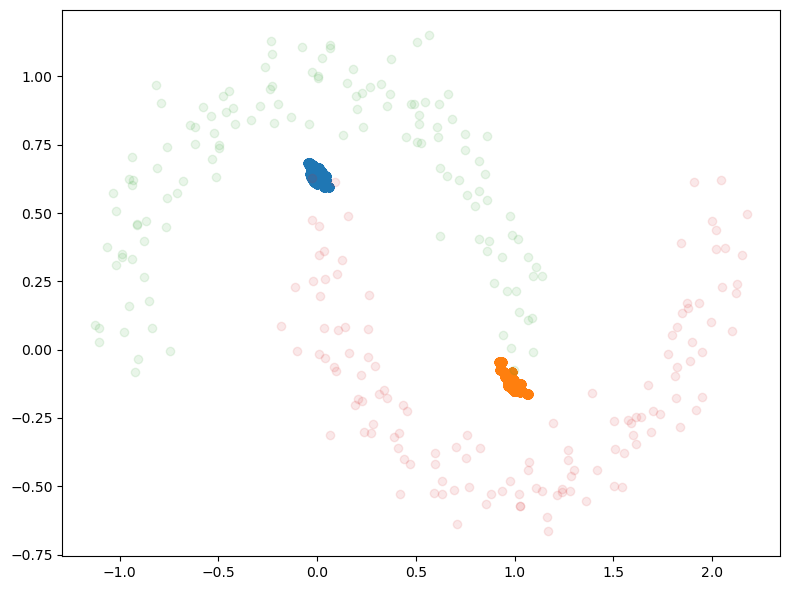

In [20]:
fig = plt.figure(figsize=(8,6))

plt.scatter(x_out[y_out==0, 0], x_out[y_out==0, 1], label="y=0")
plt.scatter(x_out[y_out==1, 0], x_out[y_out==1, 1], label="y=1")

plt.scatter(X[y==0, 0], X[y==0, 1], label="truth, y=0", alpha=0.1)
plt.scatter(X[y==1, 0], X[y==1, 1], label="truth, y=1", alpha=0.1)


plt.tight_layout()
plt.show()

In [22]:
for X, y in val_dataloader:
    X, y=X[0].cuda(), y[0].view(-1,1).cuda()
    with torch.no_grad():
        X_sample = model.sample_prior(y.float())
    break

# y_out = torch.concat([y]*len(x_out) ).flatten().cpu().numpy()
# x_out = torch.concat(x_out).cpu().numpy()

X_sample = X_sample.cpu().numpy()
X = X.cpu().numpy()

y = y.flatten().cpu().numpy()


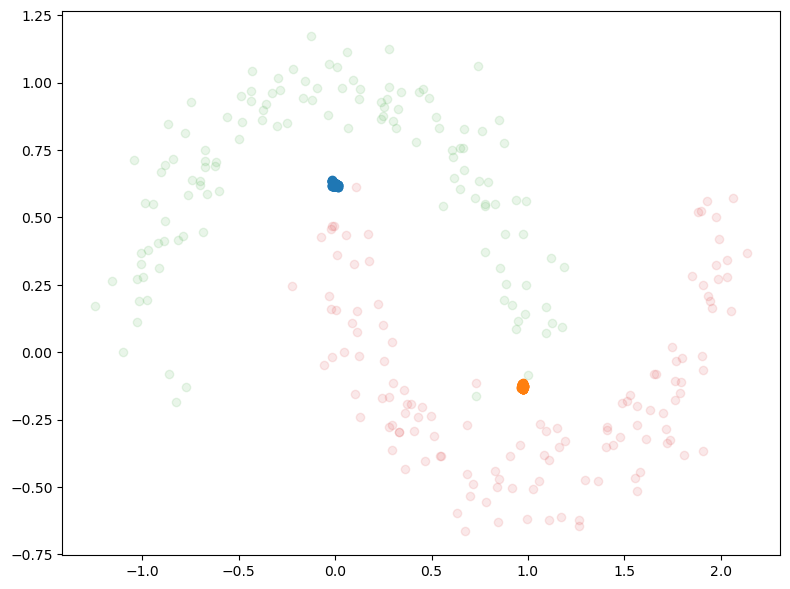

In [24]:
fig = plt.figure(figsize=(8,6))

plt.scatter(X_sample[y==0, 0], X_sample[y==0, 1], label="y=0")
plt.scatter(X_sample[y==1, 0], X_sample[y==1, 1], label="y=1")

plt.scatter(X[y==0, 0], X[y==0, 1], label="truth, y=0", alpha=0.1)
plt.scatter(X[y==1, 0], X[y==1, 1], label="truth, y=1", alpha=0.1)


plt.tight_layout()
plt.show()

In [9]:
hparams["sample_dim"] = 10
model = VAEWithGaussianDecoder(hparams).cuda()
n_epochs = 30
optimizer = torch.optim.Adam(model.parameters(), 0.001)

for i in range(n_epochs):
    train_loss, train_kl_loss, train_reco_loss = 0,0,0
    for X, y in train_dataloader:

        optimizer.zero_grad()

        X, y = X[0].to(model.device), y[0].view(-1, 1).to(model.device)

        
        x_out, mu_x, log_var_x, mu_z, log_var_z = model(X, y)

        kl_div, reco, loss = model.loss_function(x_out, mu_x, log_var_x, mu_z, log_var_z, X)

        loss.backward()

        optimizer.step()

        train_loss += loss.detach()
        train_kl_loss += kl_div.detach()
        train_reco_loss += reco.detach()
    
    train_loss /= len(train_dataloader)
    train_kl_loss /= len(train_dataloader)
    train_reco_loss /= len(train_dataloader)
    print(f"Epoch {i} --- loss: {train_loss: .3f}, KL: {train_kl_loss:.3f}, reco: {train_reco_loss: .3f}")

NameError: name 'VAEWithGaussianDecoder' is not defined

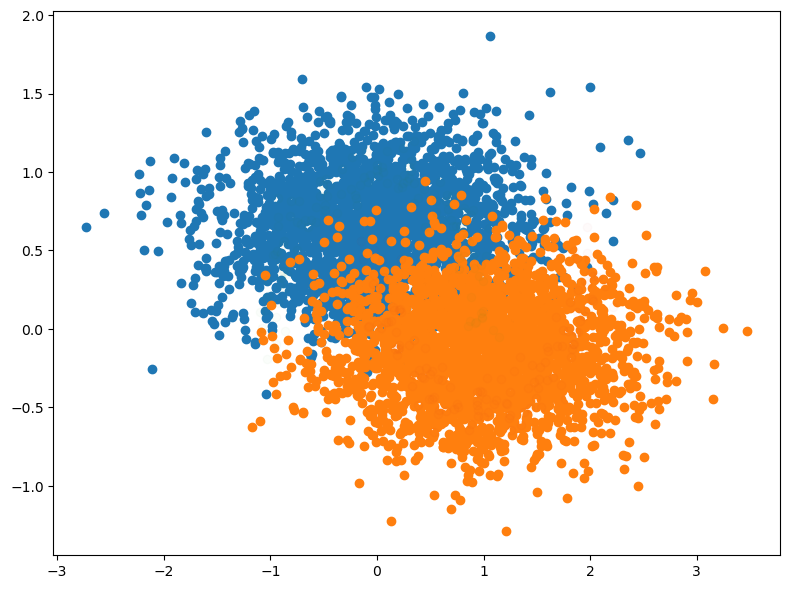

In [41]:
for X, y in val_dataloader:
    X, y=X[0].cuda(), y[0].view(-1,1).cuda()
    with torch.no_grad():
        x_out, mu_x, log_var_x, mu_z, log_var_z = model(X, y)
    break

y_out = torch.concat([y]*len(x_out) ).flatten().cpu().numpy()
x_out = torch.concat(x_out).cpu().numpy()

X = X.cpu().numpy()
y = y.flatten().cpu().numpy()

fig = plt.figure(figsize=(8,6))

plt.scatter(x_out[y_out==0, 0], x_out[y_out==0, 1], label="y=0")
plt.scatter(x_out[y_out==1, 0], x_out[y_out==1, 1], label="y=1")

plt.scatter(X[y==0, 0], X[y==0, 1], label="truth, y=0", alpha=0.02)
plt.scatter(X[y==1, 0], X[y==1, 1], label="truth, y=1", alpha=0.02)


plt.tight_layout()
plt.show()

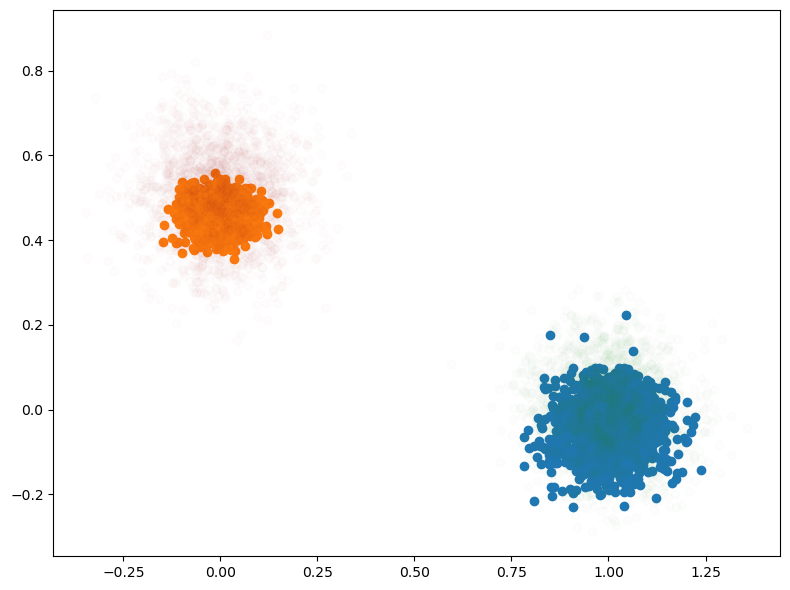

In [262]:
for X, y in val_dataloader:
    X, y=X.cuda(), y.view(-1,1).cuda()
    with torch.no_grad():
        X_sample = model.sample_prior(y.float())
    break

# y_out = torch.concat([y]*len(x_out) ).flatten().cpu().numpy()
# x_out = torch.concat(x_out).cpu().numpy()

X_sample = X_sample.cpu().numpy()
X = X.cpu().numpy()

y = y.flatten().cpu().numpy()


fig = plt.figure(figsize=(8,6))

plt.scatter(X_sample[y==0, 0], X_sample[y==0, 1], label="y=0")
plt.scatter(X_sample[y==1, 0], X_sample[y==1, 1], label="y=1")

plt.scatter(X[y==0, 0], X[y==0, 1], label="truth, y=0", alpha=0.01)
plt.scatter(X[y==1, 0], X[y==1, 1], label="truth, y=1", alpha=0.01)


plt.tight_layout()
plt.show()

In [41]:
model = VAEWithGaussianDecoderSampleZ(hparams).cuda()
n_epochs = 300
optimizer = torch.optim.Adam(model.parameters(), 0.001)

for i in range(n_epochs):
    train_loss, train_kl_loss, train_reco_loss = 0,0,0
    for X, y in train_dataloader:

        optimizer.zero_grad()

        X, y = X[0].to(model.device), y[0].view(-1, 1).to(model.device)

        
        x_out, mu_x, log_var_x, mu_z, log_var_z = model(X, y)

        kl_div, reco, loss = model.loss_function(x_out, mu_x, log_var_x, mu_z, log_var_z, X)

        loss.backward()

        optimizer.step()

        train_loss += loss.detach()
        train_kl_loss += kl_div.detach()
        train_reco_loss += reco.detach()

    train_loss /= len(train_dataloader)
    train_kl_loss /= len(train_dataloader)
    train_reco_loss /= len(train_dataloader)
    if i%10==0:
        print(f"Epoch {i} --- loss: {train_loss: .3f}, KL: {train_kl_loss:.3f}, reco: {train_reco_loss: .3f}")

Epoch 0 --- loss:  150.238, KL: -5.058, reco:  145.179
Epoch 10 --- loss:  12.654, KL: -10.172, reco:  2.482
Epoch 20 --- loss:  10.524, KL: -9.092, reco:  1.432
Epoch 30 --- loss:  10.279, KL: -8.975, reco:  1.304
Epoch 40 --- loss:  10.080, KL: -8.873, reco:  1.207
Epoch 50 --- loss:  9.938, KL: -8.779, reco:  1.158
Epoch 60 --- loss:  9.860, KL: -8.725, reco:  1.135
Epoch 70 --- loss:  9.877, KL: -8.715, reco:  1.162
Epoch 80 --- loss:  9.787, KL: -8.631, reco:  1.156
Epoch 90 --- loss:  9.786, KL: -8.612, reco:  1.175
Epoch 100 --- loss:  9.771, KL: -8.586, reco:  1.185
Epoch 110 --- loss:  9.640, KL: -8.537, reco:  1.103
Epoch 120 --- loss:  9.574, KL: -8.476, reco:  1.098
Epoch 130 --- loss:  9.538, KL: -8.424, reco:  1.113
Epoch 140 --- loss:  9.474, KL: -8.372, reco:  1.102
Epoch 150 --- loss:  9.485, KL: -8.373, reco:  1.112
Epoch 160 --- loss:  9.445, KL: -8.330, reco:  1.115
Epoch 170 --- loss:  9.404, KL: -8.288, reco:  1.116
Epoch 180 --- loss:  9.416, KL: -8.299, reco:  1

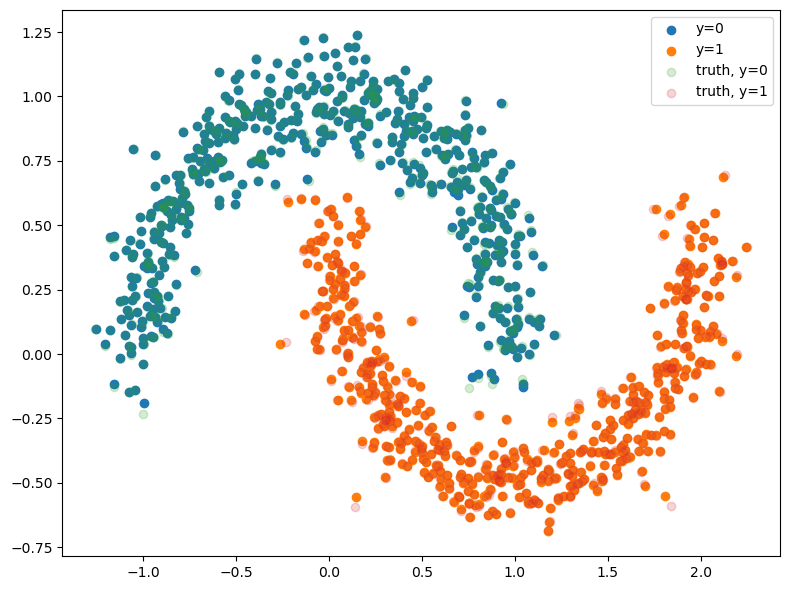

In [75]:
for X, y in val_dataloader:
    X, y=X[0].cuda(), y[0].view(-1,1).cuda()
    with torch.no_grad():
        x_out, mu_x, log_var_x, mu_z, log_var_z = model(X, y)
    break

# y_out = torch.concat([y]*len(x_out) ).flatten().cpu().numpy()
# x_out = torch.concat(mu_x, dim=0).cpu().numpy()

x_out = x_out.cpu().numpy()
y_out = y.flatten().cpu().numpy()

X = X.cpu().numpy()
y = y.flatten().cpu().numpy()

fig = plt.figure(figsize=(8,6))

plt.scatter(x_out[y_out==0, 0], x_out[y_out==0, 1], label="y=0")
plt.scatter(x_out[y_out==1, 0], x_out[y_out==1, 1], label="y=1")

plt.scatter(X[y==0, 0], X[y==0, 1], label="truth, y=0", alpha=0.2)
plt.scatter(X[y==1, 0], X[y==1, 1], label="truth, y=1", alpha=0.2)

plt.legend()

plt.tight_layout()
plt.show()

In [73]:
mu_z.shape

torch.Size([1024, 10])

In [57]:
hparams['sample_dim'] = 10
model = VAEWithGaussianDecoderSampleZV2(hparams).cuda()
n_epochs = 300
optimizer = torch.optim.Adam(model.parameters(), 0.001)

for i in range(n_epochs):
    train_loss, train_kl_loss, train_reco_loss = 0,0,0
    for X, y in train_dataloader:

        optimizer.zero_grad()

        X, y = X[0].to(model.device), y[0].view(-1, 1).to(model.device)

        
        x_out, mu_x, log_var_x, mu_z, log_var_z = model(X, y)

        kl_div, reco, loss = model.loss_function(x_out, mu_x, log_var_x, mu_z, log_var_z, X)

        loss.backward()

        optimizer.step()

        train_loss += loss.detach()
        train_kl_loss += kl_div.detach()
        train_reco_loss += reco.detach()

    train_loss /= len(train_dataloader)
    train_kl_loss /= len(train_dataloader)
    train_reco_loss /= len(train_dataloader)
    if i%50==0:
        print(f"Epoch {i} --- loss: {train_loss: .3f}, KL: {train_kl_loss:.3f}, reco: {train_reco_loss: .3f}")

Epoch 0 --- loss:  126.827, KL: -5.177, reco:  121.650
Epoch 50 --- loss: -784.980, KL: -52.639, reco: -837.619
Epoch 100 --- loss: -1973.637, KL: -56.322, reco: -2029.959
Epoch 150 --- loss: -1928.378, KL: -53.193, reco: -1981.571
Epoch 200 --- loss: -1389.080, KL: -57.146, reco: -1446.226
Epoch 250 --- loss: -1880.909, KL: -54.202, reco: -1935.110


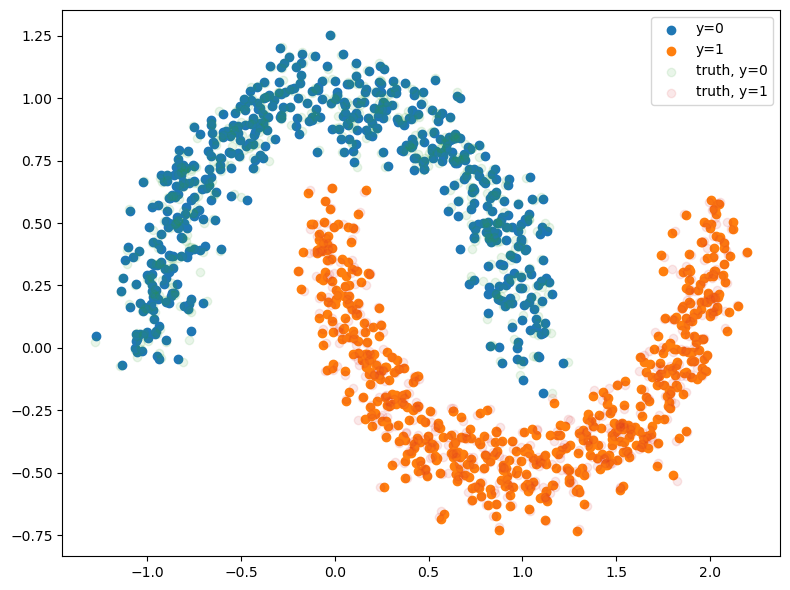

In [66]:
for X, y in val_dataloader:
    X, y=X[0].cuda(), y[0].view(-1,1).cuda()
    with torch.no_grad():
        x_out, mu_x, log_var_x, mu_z, log_var_z = model(X, y)
        x_out = model.reparameterize(mu_x, log_var_x)
    break

# y_out = torch.concat([y]*len(x_out) ).flatten().cpu().numpy()
# x_out = torch.concat(mu_x, dim=0).cpu().numpy()

x_out = x_out.cpu().numpy()
y_out = y.flatten().cpu().numpy()

X = X.cpu().numpy()
y = y.flatten().cpu().numpy()

fig = plt.figure(figsize=(8,6))

plt.scatter(x_out[y_out==0, 0], x_out[y_out==0, 1], label="y=0")
plt.scatter(x_out[y_out==1, 0], x_out[y_out==1, 1], label="y=1")

plt.scatter(X[y==0, 0], X[y==0, 1], label="truth, y=0", alpha=0.1)
plt.scatter(X[y==1, 0], X[y==1, 1], label="truth, y=1", alpha=0.1)

plt.legend()

plt.tight_layout()
plt.show()

In [64]:
y = torch.randint(0, 2,(10000,1)).to(model.device)

# mu = torch.zeros((10000, 10))
# log_var = torch.zeros((10000, 10))

# z = model.reparameterize(mu, log_var).to(model.device)



z = torch.randn((10000, 10)).to(model.device)

with torch.no_grad():
    decoded_ = model.decode(z, y)
    mu_x, log_var_x = decoded_[:, : model.x_dim], decoded_[:, model.x_dim:]
    x_out = model.reparameterize(mu_x, log_var_x).cpu()
    # x_out = mu_x.cpu()

y = y.flatten().cpu()
y_out = y

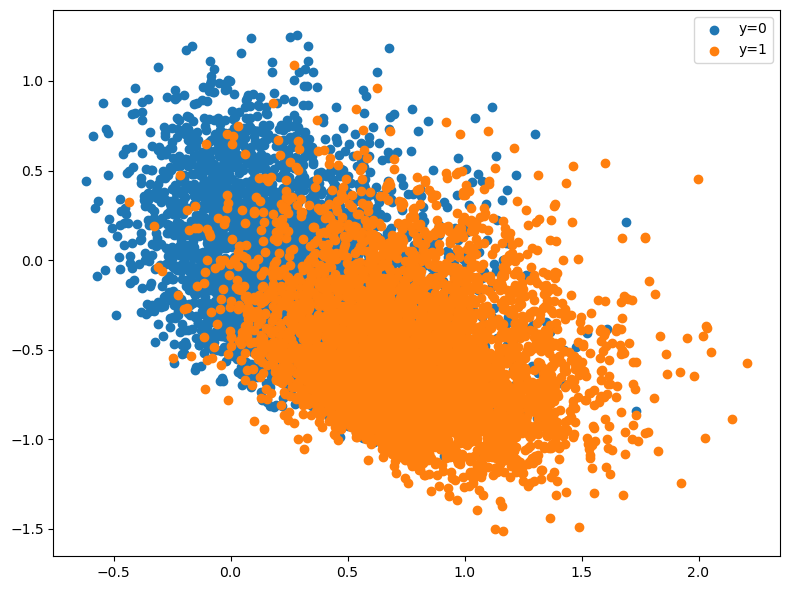

In [65]:
fig = plt.figure(figsize=(8,6))

plt.scatter(x_out[y_out==0, 0], x_out[y_out==0, 1], label="y=0")
plt.scatter(x_out[y_out==1, 0], x_out[y_out==1, 1], label="y=1")

# plt.scatter(X[y==0, 0], X[y==0, 1], label="truth, y=0", alpha=0.1)
# plt.scatter(X[y==1, 0], X[y==1, 1], label="truth, y=1", alpha=0.1)

plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model = VAEWithGaussianDecoderSampleZV3(hparams).cuda()

In [95]:
hparams['sample_dim'] = 10
# model = VAEWithGaussianDecoderSampleZV3(hparams).cuda()
n_epochs = 200
optimizer = torch.optim.Adam(model.parameters(), 0.0001)

for i in range(n_epochs):
    train_loss, train_kl_loss, train_reco_loss = 0,0,0
    for X, y in train_dataloader:

        optimizer.zero_grad()

        X, y = X[0].to(model.device), y[0].view(-1, 1).to(model.device)

        
        x_out, mu_x, log_var_x, mu_z, log_var_z = model(X, y)

        kl_div, reco, loss = model.loss_function(x_out, mu_x, log_var_x, mu_z, log_var_z, X)

        loss.backward()

        optimizer.step()

        train_loss += loss.detach()
        train_kl_loss += kl_div.detach()
        train_reco_loss += reco.detach()

    train_loss /= len(train_dataloader)
    train_kl_loss /= len(train_dataloader)
    train_reco_loss /= len(train_dataloader)
    if i%50==0:
        print(f"Epoch {i} --- loss: {train_loss: .3f}, KL: {train_kl_loss:.3f}, reco: {train_reco_loss: .3f}")

Epoch 0 --- loss:  1099.559, KL: -1641.000, reco: -541.441
Epoch 50 --- loss:  1099.846, KL: -1669.666, reco: -569.821
Epoch 100 --- loss:  1094.289, KL: -1692.432, reco: -598.143
Epoch 150 --- loss:  1103.356, KL: -1704.057, reco: -600.700


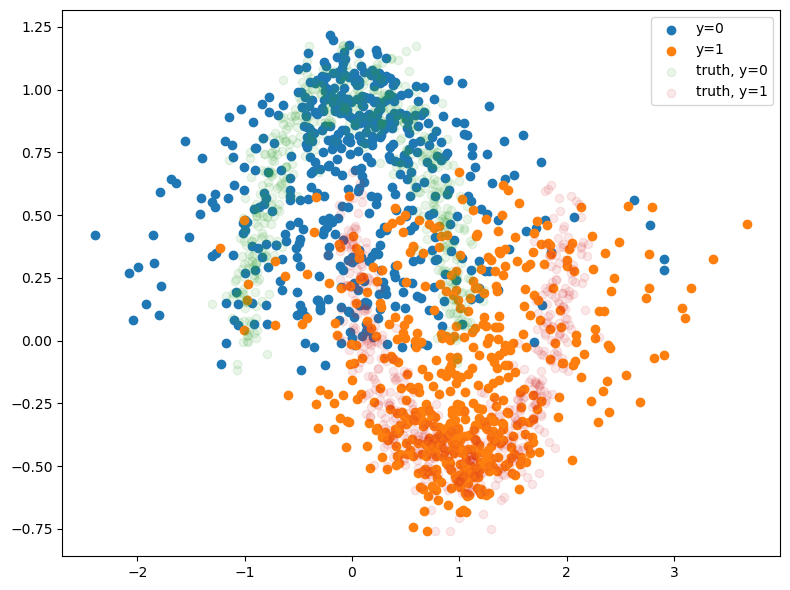

In [96]:
for X, y in val_dataloader:
    X, y=X[0].cuda(), y[0].view(-1,1).cuda()
    with torch.no_grad():
        x_out, mu_x, log_var_x, mu_z, log_var_z = model(X, y)
        x_out = model.reparameterize(mu_x, log_var_x)
    break

# y_out = torch.concat([y]*len(x_out) ).flatten().cpu().numpy()
# x_out = torch.concat(mu_x, dim=0).cpu().numpy()

x_out = x_out.cpu().numpy()
y_out = y.flatten().cpu().numpy()

X = X.cpu().numpy()
y = y.flatten().cpu().numpy()

fig = plt.figure(figsize=(8,6))

plt.scatter(x_out[y_out==0, 0], x_out[y_out==0, 1], label="y=0")
plt.scatter(x_out[y_out==1, 0], x_out[y_out==1, 1], label="y=1")

plt.scatter(X[y==0, 0], X[y==0, 1], label="truth, y=0", alpha=0.1)
plt.scatter(X[y==1, 0], X[y==1, 1], label="truth, y=1", alpha=0.1)

plt.legend()

plt.tight_layout()
plt.show()

In [97]:
y = torch.randint(0, 2,(10000,1)).to(model.device)

z = torch.randn((10000, 10)).to(model.device)

with torch.no_grad():
    decoded_ = model.decode(z, y)
    mu_x, log_var_x = decoded_[:, : model.x_dim], decoded_[:, model.x_dim:]
    x_out = model.reparameterize(mu_x, log_var_x).cpu()
    # x_out = mu_x.cpu()

y = y.flatten().cpu()
y_out = y

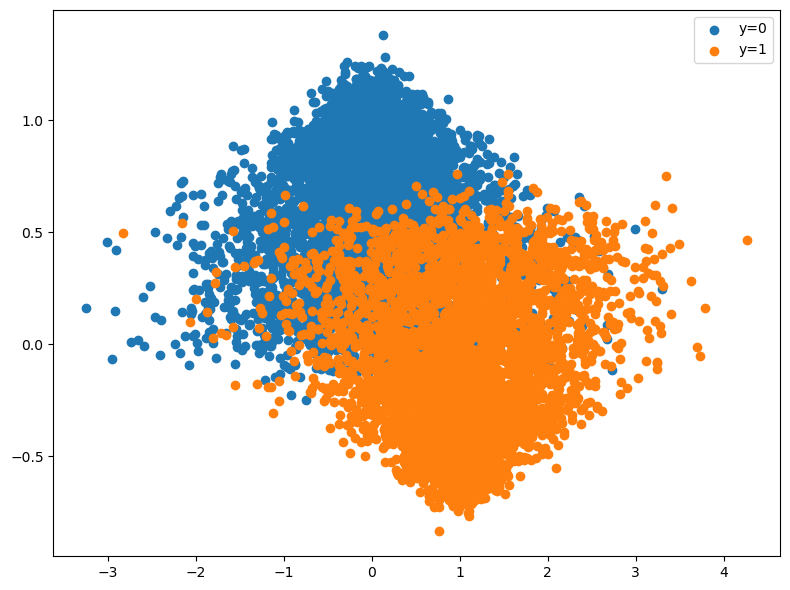

In [98]:
fig = plt.figure(figsize=(8,6))

plt.scatter(x_out[y_out==0, 0], x_out[y_out==0, 1], label="y=0")
plt.scatter(x_out[y_out==1, 0], x_out[y_out==1, 1], label="y=1")

# plt.scatter(X[y==0, 0], X[y==0, 1], label="truth, y=0", alpha=0.1)
# plt.scatter(X[y==1, 0], X[y==1, 1], label="truth, y=1", alpha=0.1)

plt.legend()

plt.tight_layout()
plt.show()

In [106]:
model = VAEWithGaussianDecoderSampleZV4(hparams).cuda()

In [ ]:
hparams['sample_dim'] = 10
# model = VAEWithGaussianDecoderSampleZV3(hparams).cuda()
n_epochs = 200
optimizer = torch.optim.Adam(model.parameters(), 0.01)

for i in range(n_epochs):
    train_loss, train_kl_loss, train_reco_loss = 0,0,0
    for X, y in train_dataloader:

        optimizer.zero_grad()

        X, y = X[0].to(model.device), y[0].view(-1, 1).to(model.device)

        
        x_out, mu_x, log_var_x, mu_z, log_var_z = model(X, y)

        kl_div, reco, loss = model.loss_function(x_out, mu_x, log_var_x, mu_z, log_var_z, X)

        loss.backward()

        optimizer.step()

        train_loss += loss.detach()
        train_kl_loss += kl_div.detach()
        train_reco_loss += reco.detach()

    
    train_loss /= len(train_dataloader)
    train_kl_loss /= len(train_dataloader)
    train_reco_loss /= len(train_dataloader)
    if i%10==0:
        print(f"Epoch {i} --- loss: {train_loss: .3f}, KL: {train_kl_loss:.3f}, reco: {train_reco_loss: .3f}")

Epoch 0 --- loss:  1305.737, KL: -1286.188, reco:  19.549
Epoch 10 --- loss:  1167.046, KL: -1280.804, reco: -113.758
Epoch 20 --- loss:  1163.918, KL: -1311.011, reco: -147.093
Epoch 30 --- loss:  1136.608, KL: -1412.978, reco: -276.369
Epoch 40 --- loss:  1122.636, KL: -1478.153, reco: -355.517
Epoch 50 --- loss:  1115.334, KL: -1475.938, reco: -360.604
Epoch 60 --- loss:  1116.410, KL: -1500.331, reco: -383.921
Epoch 70 --- loss:  1116.146, KL: -1501.134, reco: -384.988
Epoch 80 --- loss:  1115.922, KL: -1512.045, reco: -396.123
Epoch 90 --- loss:  1115.849, KL: -1516.540, reco: -400.691
Epoch 100 --- loss:  1110.126, KL: -1514.290, reco: -404.164
Epoch 110 --- loss:  1111.649, KL: -1515.080, reco: -403.431
Epoch 120 --- loss:  1110.793, KL: -1523.132, reco: -412.340
Epoch 130 --- loss:  1108.086, KL: -1523.507, reco: -415.421
Epoch 140 --- loss:  1111.099, KL: -1519.451, reco: -408.352
Epoch 150 --- loss:  1120.227, KL: -1527.334, reco: -407.107


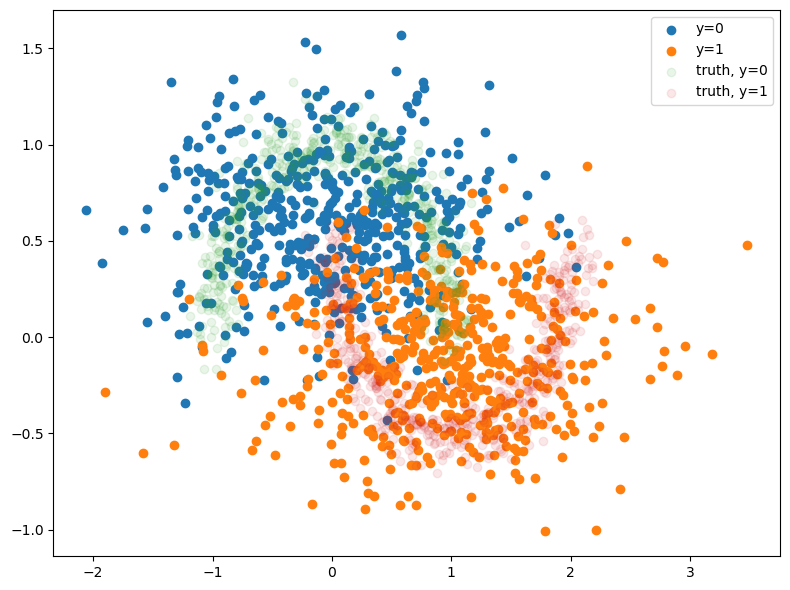

In [110]:
for X, y in val_dataloader:
    X, y=X[0].cuda(), y[0].view(-1,1).cuda()
    with torch.no_grad():
        x_out, mu_x, log_var_x, mu_z, log_var_z = model(X, y)
        x_out = model.reparameterize(mu_x[0], log_var_x[0])
    break

# y_out = torch.concat([y]*len(x_out) ).flatten().cpu().numpy()
# x_out = torch.concat(mu_x, dim=0).cpu().numpy()

x_out = x_out.cpu().numpy()
y_out = y.flatten().cpu().numpy()

X = X.cpu().numpy()
y = y.flatten().cpu().numpy()

fig = plt.figure(figsize=(8,6))

plt.scatter(x_out[y_out==0, 0], x_out[y_out==0, 1], label="y=0")
plt.scatter(x_out[y_out==1, 0], x_out[y_out==1, 1], label="y=1")

plt.scatter(X[y==0, 0], X[y==0, 1], label="truth, y=0", alpha=0.1)
plt.scatter(X[y==1, 0], X[y==1, 1], label="truth, y=1", alpha=0.1)

plt.legend()

plt.tight_layout()
plt.show()

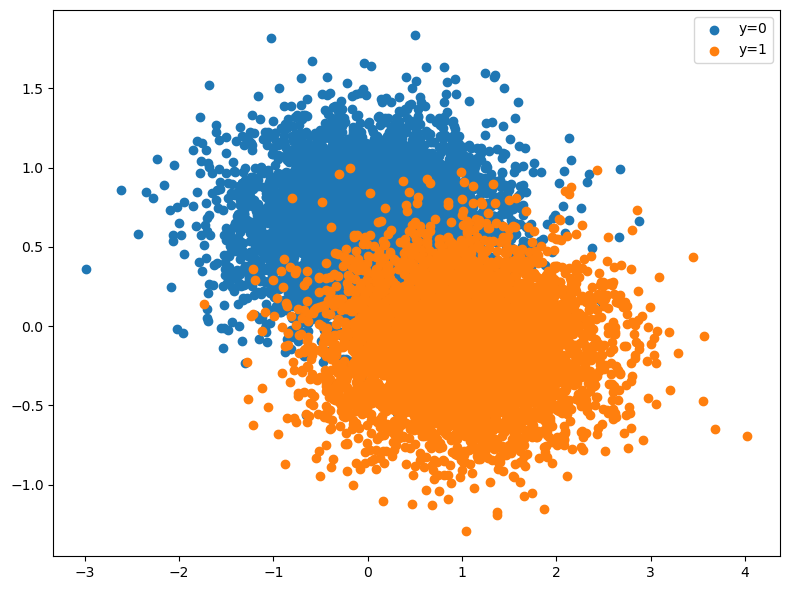

In [112]:
y = torch.randint(0, 2,(10000,1)).to(model.device)

z = torch.randn((10000, 10)).to(model.device)

with torch.no_grad():
    decoded_ = model.decode(z, y)
    mu_x, log_var_x = decoded_[:, : model.x_dim], decoded_[:, model.x_dim:]
    x_out = model.reparameterize(mu_x, log_var_x).cpu()
    # x_out = mu_x.cpu()

y = y.flatten().cpu()
y_out = y

fig = plt.figure(figsize=(8,6))

plt.scatter(x_out[y_out==0, 0], x_out[y_out==0, 1], label="y=0")
plt.scatter(x_out[y_out==1, 0], x_out[y_out==1, 1], label="y=1")

# plt.scatter(X[y==0, 0], X[y==0, 1], label="truth, y=0", alpha=0.1)
# plt.scatter(X[y==1, 0], X[y==1, 1], label="truth, y=1", alpha=0.1)

plt.legend()

plt.tight_layout()
plt.show()